# Set up environment and import packages

In [2]:
# @title Install packages
!pip install pip --upgrade --quiet
!pip install git+https://github.com/slinderman/AllenSDK@master --quiet
!pip install brain_observatory_utilities --quiet
!pip install pandas --quiet
!pip install seaborn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 25.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 65.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 57.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.3/130.3 kB 794.3 kB/s eta 0:00:00
     ━━━━━

#### Import packages

In [3]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.manifold import TSNE

import brain_observatory_utilities.datasets.optical_physiology.data_formatting as ophys_formatting
import brain_observatory_utilities.utilities.general_utilities as utilities

from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

from tqdm import tqdm
import brain_observatory_utilities.datasets.optical_physiology.data_formatting as ophys_formatting

import torch
from torch import nn
from torch import optim

pd.set_option('display.max_columns', 500)

# Load data
The AllenSDK provides functionality for downloading tables that describe all sessions and experiments (individual imaging planes) in the Visual Behavior 2P dataset. We first download the data cache:

In [4]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
data_storage_directory = "/content/drive/MyDrive/allen_cache" # Note: this path must exist on your local drive
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=data_storage_directory)

import sys
sys.path.append('/content/drive/MyDrive/ColabNotebooks')
from loaddata import get_experiments, get_neural_data

Mounted at /content/drive


- `Ophys_session_table` contains metadata describing imaging sessions. If more than one plane was imaged during a session, one ophys session id will be associated multiple ophys experiment ids. Each ophys session id will also have a unique behavior session id.
- `Behavior_session_table` contains metadata describing behavioral sessions, which may or may not be during imaging. Behavior session ids that do not have ophys session ids were training sessions.
- `Ophys_experiment_table` contains metadata describing imaging experiments (aka imaging planes). When mesoscope is used, one ophys session may contain up to 8 unique experiments (two visual areas by four imaging depths). Some imaging planes may not be released due to quality control issues, thus each ophys session id is associated with anywhere from one to eight unique experiment ids. Ophys experiment ids are unique and do not repeat across sessions. To find the same imaging plane that was matched across multiple sessions, use the `ophys_container_id` column that can be found in both `ophys_session_table` and `ophys_experiment_table`.

Note that a 'session' is a single behavioral session. Sessions that are performed on the mesoscope will have multiple (up to 8) 'experiments' associated with them, where an experiment is a distinct imaging plane.

In [5]:
session_table = cache.get_ophys_session_table()
experiment_table = cache.get_ophys_experiment_table()

In [6]:
experiment_table['cre_line'].unique()

array(['Sst-IRES-Cre', 'Vip-IRES-Cre', 'Slc17a7-IRES2-Cre'], dtype=object)

In [7]:
experiments, ophys_experiment_ids = get_experiments(cache, structures=['VISp'], passive=False, unique_session=True, unique_mouse=True) # excitatory cells
#experiments, ophys_experiment_ids = get_experiments(cache, structures=['VISp'], passive=False, cre_lines=['Vip-IRES-Cre'], unique_session=True, unique_mouse=True) # inhibitory cells

loading 4 experiments.


/usr/local/lib/python3.10/dist-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.3.0 because version 1.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/usr/local/lib/python3.10/dist-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/usr/local/lib/python3.10/dist-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.3.0 because version 1.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/usr/local/lib/python3.10/dist-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespa

Note that the `tidy` format means that each row has only one observation, which represents a single GCaMP6 fluorescnce value for a single neuron.

In [8]:
neural_data = get_neural_data(experiments)
neural_data.head()

100%|██████████| 4/4 [00:06<00:00,  1.62s/it]


,timestamps,dff,events,filtered_events,cell_roi_id,cell_specimen_id,ophys_experiment_id,ophys_session_id,targeted_structure,imaging_depth,equipment_name,cre_line,mouse_id,sex
0,9.55381,0.253982,0.0,0.0,1080671244,1086594438,990400779,990139534,VISp,None,MESO.1,Slc17a7-IRES2-Cre,479839,M
1,9.64702,0.295031,0.0,0.0,1080671244,1086594438,990400779,990139534,VISp,None,MESO.1,Slc17a7-IRES2-Cre,479839,M
2,9.74023,0.109215,0.0,0.0,1080671244,1086594438,990400779,990139534,VISp,None,MESO.1,Slc17a7-IRES2-Cre,479839,M
3,9.83344,0.174382,0.0,0.0,1080671244,1086594438,990400779,990139534,VISp,None,MESO.1,Slc17a7-IRES2-Cre,479839,M
4,9.92665,0.102353,0.0,0.0,1080671244,1086594438,990400779,990139534,VISp,None,MESO.1,Slc17a7-IRES2-Cre,479839,M


- The `cell_roi_id` column contains unique roi ids for all cells in a given experiment, which do not repeat across ophys sessions.
- The `cell_specimen_id` column contains unique ids for cells that were matched across ophys sessions. Thus, a cell that was imaged in more than one session has multiple roi ids but one cell specimen id.

In [9]:
# stimulus_table = experiments[ophys_experiment_ids[0]].stimulus_presentations
stimulus_table = pd.concat([experiments[ophys_experiment_ids[i]].stimulus_presentations for i in range(4)], ignore_index=True)
experiment = experiments[ophys_experiment_ids[0]]
stimulus_table.head()

,duration,end_frame,flashes_since_change,image_index,image_name,is_change,omitted,start_frame,start_time,end_time
0,0.25016,18001.0,0.0,0,im000,False,False,17986,309.55898,309.80914
1,0.25021,18046.0,1.0,0,im000,False,False,18031,310.30959,310.55980
2,0.25018,18091.0,2.0,0,im000,False,False,18076,311.06020,311.31038
3,0.25020,18136.0,3.0,0,im000,False,False,18121,311.81082,312.06102
4,0.25021,18181.0,4.0,0,im000,False,False,18166,312.56143,312.81164


In [10]:
# Examine Cell IDs
cell_ids = neural_data['cell_specimen_id'].unique()

Each cell has three types of traces:

dff column is the Calcium fluorescence signal, normalized to background fluorescence.
events column is deconvolved events from dff trace, which approximates neural firing rate and removes the slow decay of the Calcium signal (for more details, you can read EVENT DETECTION section in Visual Behavior whitepaper).
filtered_events column is events smoothed with a half-gaussian kernel.

# Plot an event triggered response
If we make a wrapper function that combines the process of calculating and plotting the event triggered response, it can be called in a single line below. By having `event_query` input variable, we can use this function to plot responses to any event of interest (omisisons, changes, hits/misses, specific images, etc)

In [11]:
def make_event_triggered_plot(df, x, y, event_query, ax, t_before=3, t_after=3):
    etr = utilities.event_triggered_response(
      data=df,
      t='timestamps',
      y=y,
      event_times=event_query,                                              # <--
      t_before=t_before,
      t_after=t_after,                                                      # <--
      output_sampling_rate=50,
      )
    sns.lineplot(
      data=etr,
      x=x,
      y=y,
      n_boot=500,
      ax=ax
      )

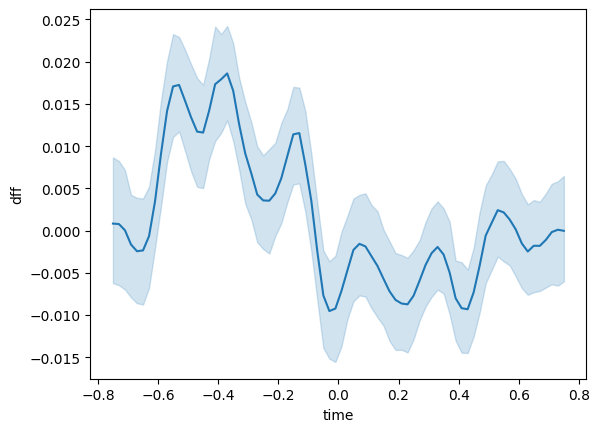

In [12]:
cell_id = cell_ids[11]
fig, ax = plt.subplots()
make_event_triggered_plot(
    df=neural_data.query('cell_specimen_id == @cell_id'),
    x='time',
    # --- Filtered or unfiltered data ---------------------------------
    y = 'dff',                                                             # deltaF/F value surrounding each event
    #y='filtered_events',                                                   # filtered events
    # --- Events ------------------------------------------------------
    event_query=stimulus_table.query('omitted')['start_time'],             # Omitted stimuli
    #event_query=stimulus_table[~stimulus_table['omitted']]['start_time'],  # Presented stimuli
    #event_query=experiment.licks.timestamps,                               # Licks
    #event_query=experiment.rewards.timestamps,                             # Rewards

    ax=ax,
    t_before=.75,
    t_after=.75
)
fig.show()

# Set up data for scikit learn
To use scikit-learn for a decoding or clustering analysis we need to get the data into a standard format for scikit learn, which is often a feature matrix (`X`) and a vector of labels (`y`).

We now look at the responses to each of the stimuli in this session, which consists of 8 unique images, plus the omitted stimuli (which we characterize as a unique stimulus type). First, we will calculate an event triggered response to each stimulus start time in the stimulus table.

In [13]:
full_etr_l = []
# iterate over each unique cell
for cell_specimen_id in tqdm(neural_data['cell_specimen_id'].unique()):
  # calculate the event triggered response for this cell to every stimulus
  full_etr_this_cell = utilities.event_triggered_response(
      neural_data.query('cell_specimen_id == @cell_specimen_id'),
      t='timestamps',
      y='dff',
      event_times=stimulus_table['start_time'],
      t_before=0,
      t_after=0.75,
      interpolate = False
      #output_sampling_rate=30
  )
  # add a column identifying the cell_specimen_id
  full_etr_this_cell['cell_specimen_id'] = cell_specimen_id
  # append to our list
  full_etr_l.append(full_etr_this_cell)

# concatenate our list of dataframes into a single dataframe
full_etr = pd.concat(full_etr_l)

# cast these numeric columns to int and float, respectively
full_etr['event_number'] = full_etr['event_number'].astype(int)
full_etr['event_time'] = full_etr['event_number'].astype(float)


100%|██████████| 268/268 [05:21<00:00,  1.20s/it]


One way to construct a feature matrix might be to build it such that dimensions are `trials x cells`. Thus:

* Each row would be one trial, where a trial is defined as a unique image presentation
* Each column would represent the average response of a given cell on that image presentation.

To do so, let's construct another intermediate dataframe called `average_responses` that contains the average response of each cell (in the 750 ms window we've selected above) to each image presentation. We'll do this using a Pandas groupby to group by `cell_specimen_id` and `stimulus_presentations_id` (aka trial).

We're also going to merge in our stimulus metadata.

In [14]:
average_responses = full_etr.groupby(['cell_specimen_id', 'original_index'])[['dff']].mean().reset_index().merge(
    stimulus_table,
    on='original_index',
    how='left'
)
average_responses.head()

,cell_specimen_id,original_index,dff,duration,end_frame,flashes_since_change,image_index,image_name,is_change,omitted,start_frame,start_time,end_time
0,1086510464,0,0.011043,0.25016,18001.0,0.0,0,im000,False,False,17986,309.55898,309.80914
1,1086510464,1,-0.048578,0.25021,18046.0,1.0,0,im000,False,False,18031,310.30959,310.55980
2,1086510464,2,0.026204,0.25018,18091.0,2.0,0,im000,False,False,18076,311.06020,311.31038
3,1086510464,3,-0.022699,0.25020,18136.0,3.0,0,im000,False,False,18121,311.81082,312.06102
4,1086510464,4,0.008664,0.25021,18181.0,4.0,0,im000,False,False,18166,312.56143,312.81164


Now we can construct a dataframe called `features_and_labels` that will contain one row per trial, one column per cell, plus columns with the image_index and image_name

In [15]:
features_and_labels = average_responses.pivot(
    index='original_index',
    columns='cell_specimen_id',
    values='dff'
).merge(
    stimulus_table[['image_index','image_name']],
    on='original_index',
    how='left'
)
features_and_labels.dropna(inplace=True)

In [17]:
X = features_and_labels[cell_ids]

In [18]:
y = features_and_labels['image_index']

Split our data into train and test sets.



In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

Run on GPU.

In [16]:
device = 'cuda'

## Dimensionality reduction: PCA

In [20]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scaler = StandardScaler()
data_standardized = scaler.fit_transform(X.values)
pca = PCA(n_components=0.95) # Keep components that explain 95% of the variance
data_pca = pca.fit_transform(data_standardized)
explained_variance_ratio = pca.explained_variance_ratio_

In [21]:
print('{} out of {} neurons explain 95 % of variance'.format(len(explained_variance_ratio),X.shape[1]))

234 out of 268 neurons explain 95 % of variance


-> 234 out of 268 neurons explain 95 % of variance

Looks like print outputs aren't saved/shown. I'll include them manually and indicate them by adding '->' at the beginning of the line from here on.

Since 87% of neurons are required to explain 95 % of variance in the data, we didn't use dimensionality reduction.

# Neural Network

Here we apply *deep logistic regression* using a *multilayer perceptron* to classify the presented images and omitted stimuli -> 9 classes.


In [22]:
from torch.utils.data import TensorDataset, DataLoader

class DeepNetReLU(nn.Module):
  def __init__(self, n_inputs, n_outputs, n_hidden = []):
    super().__init__()
    inputs = n_inputs
    layers = []
    for h in n_hidden:
      layers.append(nn.Linear(inputs,h))
      layers.append(nn.Dropout(.35))
      inputs = h
    layers.append(nn.Linear(inputs,n_outputs))
    self.layers = nn.ModuleList(layers)

  def forward(self, r):
    for i,layer in enumerate(self.layers):
      r = layer(r)
      if i < len(self.layers)-1:
        r = torch.relu(r)
    return r

In [23]:
def plot_train_loss(train_loss):
  plt.plot(train_loss)
  plt.xlim([0, None])
  plt.ylim([0, None])
  plt.xlabel('Epochs')
  plt.ylabel('Cross Entropy Loss')
  plt.show()

In [24]:
def eval(net, dataset, batch_size):
    net.eval()
    dataloader = DataLoader(dataset, batch_size=batch_size)
    correct = 0
    n = 0
    for x, y in dataloader:
        with torch.no_grad():
            b_size = len(x)
            out = net(x)
            pred = out.data.max(1, keepdim=False)[1]
            correct += torch.eq(pred, y.squeeze(1)).sum()
            n += b_size
    return (correct / n).item()


def train(net, loss_fn, train_dataset, test_dataset, batch_size, train_loss, accuracies, val_accs,
          n_epochs=50, learning_rate=1e-4):
  """Run gradient descent to optimize parameters of a given network

  Args:
    net (nn.Module): PyTorch network whose parameters to optimize
    loss_fn: built-in PyTorch loss function to minimize
    train_data (torch.Tensor): n_train x n_neurons tensor with neural
      responses to train on
    train_labels (torch.Tensor): n_train x 1 tensor with orientations of the
      stimuli corresponding to each row of train_data
    n_epochs (int, optional): number of epochs of gradient descent to run
    learning_rate (float, optional): learning rate to use for gradient descent

  Returns:
    (list): training loss over iterations

  """

  # Initialize PyTorch SGD optimizer
  optimizer = optim.AdamW(net.parameters(), lr=learning_rate, weight_decay=.2)
  n_trials = len(train_dataset)

  # Loop over epochs
  for epoch in range(n_epochs):
      net.train()
      epoch_correct = 0
      dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
      epoch_losses = torch.zeros(len(dataloader))

      for batch_idx, (x, y) in enumerate(dataloader):
          # compute network output from inputs in train_data
          out = net(x) # compute network output from inputs in train_data

          # evaluate loss function
          # print(f"out.dtype: {out.dtype} - y.dtype: {y.dtype} - y: {y.squeeze(1)}")
          loss = loss_fn(out, y.squeeze(1))

          # Clear previous gradients
          optimizer.zero_grad()

          # Compute gradients
          loss.backward()

          # Update weights
          # optimizer = optim.SGD(net.parameters(), lr=.001)
          optimizer.step()

          # Store current value of loss
          epoch_losses[batch_idx] = loss.item()  # .item() needed to transform the tensor output of loss_fn to a scalar

          # Accuracy
          pred = out.data.max(1, keepdim=True)[1]
          batch_correct = torch.eq(pred.squeeze(1), y.squeeze(1)).sum()
          epoch_correct += batch_correct

      accuracies.append((100 * epoch_correct / n_trials).item())
      train_loss.append((epoch_losses.mean()))
      val_accs.append(100 * eval(net, test_dataset, batch_size))

      # Track progress
      if (epoch + 1) % 25 == 0:
        print(f'iteration {epoch + 1}/{n_epochs} | loss: {loss.item():.5f} | acc: {accuracies[-1]:.3f} | val_acc: {val_accs[-1]:.3f}')

  return train_loss, accuracies, val_accs

In [25]:
# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

BATCH_SIZE = 256

n_trials, n_neurons = X.shape

# Placeholder to save the loss at each iteration
train_loss = []
accuracies = []
val_accs = []

# Initialize network with 10 hidden units
net = DeepNetReLU(n_neurons, len(y.unique()), [64,32]).to(device)
print(f"Building network with {n_neurons} inputs and {len(y.unique())} outputs")

# Initialize built-in PyTorch MSE loss function
loss_fn = nn.CrossEntropyLoss()

# Return as torch.Tensor
# Train
X_train_nn = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train_nn = torch.tensor(y_train.values, dtype=torch.uint8).reshape(-1, 1).to(device)  # add singleton dimension to make a column vector
train_dataset = TensorDataset(X_train_nn, y_train_nn)
# Test
X_test_nn = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_nn = torch.tensor(y_test.values, dtype=torch.uint8).reshape(-1, 1).to(device)  # add singleton dimension to make a column vector
test_dataset = TensorDataset(X_test_nn, y_test_nn)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

Building network with 268 inputs and 9 outputs


iteration 25/1000 | loss: 2.00925 | acc: 37.746 | val_acc: 41.222
iteration 50/1000 | loss: 1.33302 | acc: 58.268 | val_acc: 66.450
iteration 75/1000 | loss: 1.41508 | acc: 65.407 | val_acc: 72.770
iteration 100/1000 | loss: 1.16729 | acc: 70.232 | val_acc: 74.928
iteration 125/1000 | loss: 1.08718 | acc: 73.724 | val_acc: 76.359
iteration 150/1000 | loss: 0.87613 | acc: 75.284 | val_acc: 77.451
iteration 175/1000 | loss: 1.15754 | acc: 76.910 | val_acc: 78.492
iteration 200/1000 | loss: 0.49972 | acc: 78.503 | val_acc: 79.298
iteration 225/1000 | loss: 0.85076 | acc: 79.043 | val_acc: 79.974
iteration 250/1000 | loss: 0.23262 | acc: 79.693 | val_acc: 80.546
iteration 275/1000 | loss: 1.10420 | acc: 80.512 | val_acc: 81.248
iteration 300/1000 | loss: 0.90246 | acc: 80.896 | val_acc: 81.612
iteration 325/1000 | loss: 0.49742 | acc: 81.845 | val_acc: 82.315
iteration 350/1000 | loss: 0.34116 | acc: 82.157 | val_acc: 82.965
iteration 375/1000 | loss: 0.39390 | acc: 82.840 | val_acc: 83.48

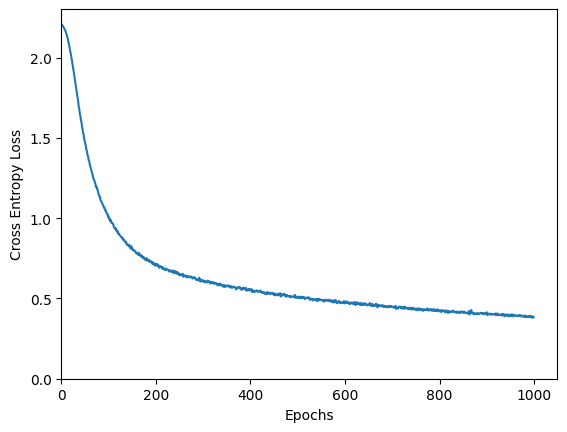

In [26]:
# Run gradient descent on data
# train_loss, correct = train(net, loss_fn, X_train_nn, y_train_nn, train_loss, n_epochs=10000, learning_rate=3e-1)
train_loss, accuracies, val_accs = train(net, loss_fn, train_dataset, test_dataset, BATCH_SIZE, train_loss, accuracies, val_accs, n_epochs=1000, learning_rate=3e-5)

# Plot the training loss over iterations of GD
plot_train_loss(train_loss)

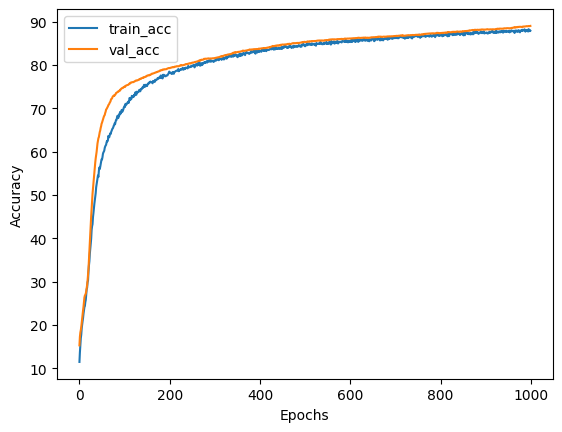

In [27]:
# Plot
fig = plt.figure(dpi=100)
plt.plot(accuracies, label="train_acc")
plt.plot(val_accs, label="val_acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
# plt.savefig('neuralNetwork_inhibitory.png')
plt.show()

We couldn't load enough data because some data was corrupted and we didn't have enough RAM in google colab (-> lesson learned to run locally in the future), which is why we are overfitting.

# Other decoders

This wasn't part of the final project, however to implement a few things of what we learned, here are the implementations of a few other decoders.

Split our data into train and test sets.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Support vector machine (SVM)

In [29]:
# Define the model
model_svm = svm.SVC(probability=True)
model_svm.fit(X_train, y_train)

# Fit model to data
model_svm.fit(X_train, y_train)

# Classify
y_pred_svm_test = model_svm.predict(X_test)

# Evaluate test accuracy
acc_svm_test = accuracy_score(y_test, y_pred_svm_test)
print('SVM test accuracy: {}'.format(acc_svm_test))

# Evaluate train accuracy -> check for overfitting
y_pred_svm_train = model_svm.predict(X_train)
acc_svm_train = accuracy_score(y_train, y_pred_svm_train)
print('SVM training accuracy: {}'.format(acc_svm_train))

SVM test accuracy: 0.8153446033810143
SVM training accuracy: 0.8471942258924507


-> SVM test accuracy: 0.8153446033810143

-> SVM training accuracy: 0.8471942258924507

Evaluate the confusion matrix

In [30]:
pd.DataFrame(
    confusion_matrix(y_test, y_pred_svm_test),
    columns=['predicted_{}'.format(im) for im in model_svm.classes_],
    index=['actual_{}'.format(im) for im in model_svm.classes_]
)

,predicted_0,predicted_1,predicted_2,predicted_3,predicted_4,predicted_5,predicted_6,predicted_7,predicted_8
actual_0,499,0,3,0,16,47,3,1,1
actual_1,20,407,0,2,4,44,2,0,2
actual_2,36,1,273,0,0,29,0,18,1
actual_3,9,0,1,389,5,19,0,1,0
actual_4,70,0,0,0,311,96,0,3,3
actual_5,39,0,0,4,7,453,0,1,0
actual_6,40,0,1,5,1,39,383,0,2
actual_7,42,0,1,0,3,39,0,323,1
actual_8,28,0,0,2,5,8,5,0,97


This tells us that the model can decode some stimuli well (im035, im075 and im106, for example), while it struggles more with others (im000 and omissions, for example).

## Logistic Regression

In [31]:
from sklearn.linear_model import LogisticRegression

# Define the model
log_reg = LogisticRegression(penalty=None, max_iter=5000)

# Fit model to data
log_reg.fit(X_train, y_train)

# Classify
y_pred_logreg_test = log_reg.predict(X_test)

# Evaluate test accuracy
acc_logreg_test = accuracy_score(y_test, y_pred_logreg_test)
print('Logistic regression test accuracy: {}'.format(acc_logreg_test))

# Evaluate train accuracy -> check for overfitting
y_pred_logreg_train = log_reg.predict(X_train)
acc_logreg_train = accuracy_score(y_train, y_pred_logreg_train)
print('Logistic regression training accuracy: {}'.format(acc_logreg_train))

Logistic regression test accuracy: 0.8850455136540962
Logistic regression training accuracy: 0.921581377202679


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


-> Logistic regression test accuracy: 0.8850455136540962

-> Logistic regression training accuracy: 0.921581377202679

## L2-regularized Logistic Regression

In [32]:
# Define the model
l2_log_reg = LogisticRegression(penalty="l2", C=1, max_iter=5000)

# Fit model to data
l2_log_reg.fit(X_train, y_train)

# Classify
y_pred_l2logreg_test = l2_log_reg.predict(X_test)

# Evaluate test accuracy
acc_l2logreg_test = accuracy_score(y_test, y_pred_l2logreg_test)
print('Logistic regression test accuracy: {}'.format(acc_l2logreg_test))

# Evaluate train accuracy -> check for overfitting
y_pred_l2logreg_train = l2_log_reg.predict(X_train)
acc_l2logreg_train = accuracy_score(y_train, y_pred_l2logreg_train)
print('Logistic regression training accuracy: {}'.format(acc_l2logreg_train))

Logistic regression test accuracy: 0.8507152145643693
Logistic regression training accuracy: 0.8765849535080305


-> Logistic regression test accuracy: 0.8507152145643693

-> Logistic regression training accuracy: 0.8765849535080305

## Linear Discriminant Analysis (LDA)

In [33]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Define the model
lda = LDA()

# Fit model to data
lda.fit(X_train, y_train)

# Classify
y_pred_lda_test = lda.predict(X_test)

# Evaluate test accuracy
acc_lda_test = accuracy_score(y_test, y_pred_lda_test)
print('LDA test accuracy: {}'.format(acc_lda_test))

# Evaluate train accuracy -> check for overfitting
y_pred_lda_train = log_reg.predict(X_train)
acc_lda_train = accuracy_score(y_train, y_pred_lda_train)
print('LDA training accuracy: {}'.format(acc_lda_train))

LDA test accuracy: 0.7890767230169051
LDA training accuracy: 0.921581377202679


-> LDA test accuracy: 0.7890767230169051

-> LDA training accuracy: 0.921581377202679

# Cross-validation

In [34]:
from sklearn.model_selection import cross_val_score

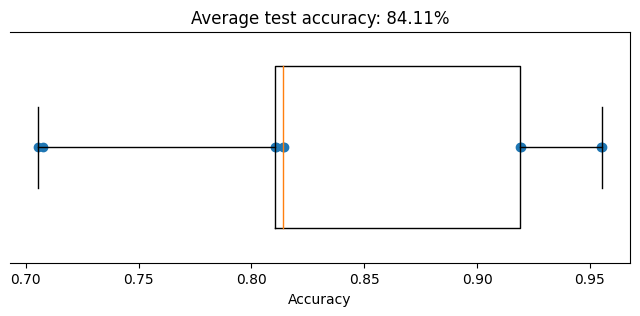

In [35]:
# SVM
accuracies_svm = cross_val_score(svm.SVC(probability=True), X, y, cv=10)  # k=10 cross validation

# Plot accuracy scores
f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(accuracies_svm, vert=False, widths=.7)
ax.scatter(accuracies_svm, np.ones(10))
ax.set(
  xlabel="Accuracy",
  yticks=[],
  title=f"Average test accuracy: {accuracies_svm.mean():.2%}"
)
ax.spines["left"].set_visible(False)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

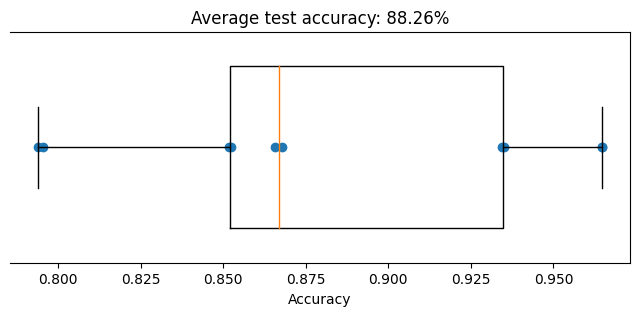

In [36]:
# Logistic regression
accuracies_logreg = cross_val_score(LogisticRegression(penalty=None), X, y, cv=10)  # k=10 cross validation

# Plot accuracy scores
f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(accuracies_logreg, vert=False, widths=.7)
ax.scatter(accuracies_logreg, np.ones(10))
ax.set(
  xlabel="Accuracy",
  yticks=[],
  title=f"Average test accuracy: {accuracies_logreg.mean():.2%}"
)
ax.spines["left"].set_visible(False)
plt.show()

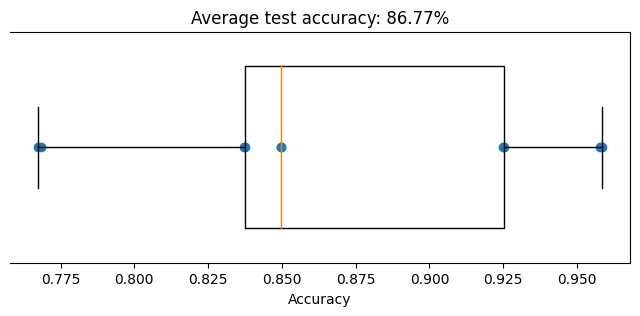

In [37]:
# L2-regularized logistic regression
accuracies_logreg = cross_val_score(LogisticRegression(penalty="l2", C=1, max_iter=5000), X, y, cv=10)  # k=10 cross validation

# Plot accuracy scores
f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(accuracies_logreg, vert=False, widths=.7)
ax.scatter(accuracies_logreg, np.ones(10))
ax.set(
  xlabel="Accuracy",
  yticks=[],
  title=f"Average test accuracy: {accuracies_logreg.mean():.2%}"
)
ax.spines["left"].set_visible(False)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

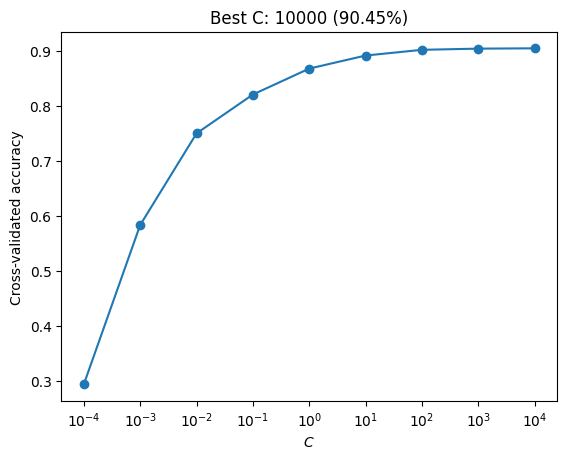

In [38]:
# L2-regularized logistic regression with different hyperparameters (C)

def plot_model_selection(C_values, accuracies):
  """Plot the accuracy curve over log-spaced C values."""
  ax = plt.figure().subplots()
  ax.set_xscale("log")
  ax.plot(C_values, accuracies, marker="o")
  best_C = C_values[np.argmax(accuracies)]
  ax.set(
      xticks=C_values,
      xlabel="$C$",
      ylabel="Cross-validated accuracy",
      title=f"Best C: {best_C:1g} ({np.max(accuracies):.2%})",
  )
  plt.show()

def model_selection(X, y, C_values):
  """Compute CV accuracy for each C value.

  Args:
    X (2D array): Data matrix
    y (1D array): Label vector
    C_values (1D array): Array of hyperparameter values

  Returns:
    accuracies (1D array): CV accuracy with each value of C

  """

  accuracies_l2reg = []
  for C in C_values:

    # Initialize and fit the model
    model_l2 = LogisticRegression(penalty="l2", C=C, max_iter=5000)
    model_l2.fit(X, y)

    # Get the accuracy for each test split using cross-validation
    accs = cross_val_score(model_l2, X, y, cv=10)  # k=10 cross validation

    # Store the average test accuracy for this value of C
    accuracies_l2reg.append(accs.mean())

  return accuracies_l2reg


# Use log-spaced values for C
C_values = np.logspace(-4, 4, 9)

# Compute accuracies
accuracies_l2reg = model_selection(X, y, C_values)

# Visualize
plot_model_selection(C_values, accuracies_l2reg)

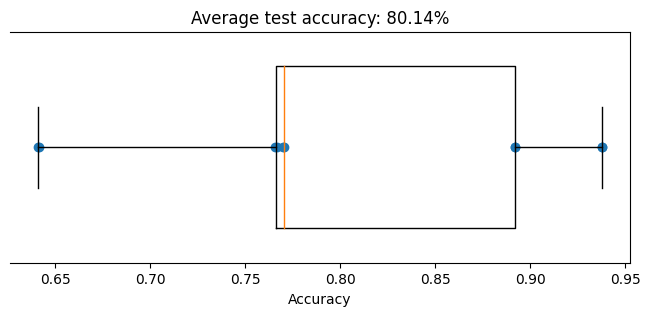

In [39]:
# LDA
accuracies_lda = cross_val_score(LDA(), X, y, cv=10)  # k=10 cross validation

# Plot accuracy scores
f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(accuracies_lda, vert=False, widths=.7)
ax.scatter(accuracies_lda, np.ones(10))
ax.set(
  xlabel="Accuracy",
  yticks=[],
  title=f"Average test accuracy: {accuracies_lda.mean():.2%}"
)
ax.spines["left"].set_visible(False)
plt.show()